In [1]:
import os

import matplotlib.pyplot as plt
import scanpy as sc
import scvi

/local/data/scvi-tools/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/local/data/scvi-tools/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
save_path = "data"
url = (
    "https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true"
)
adata = sc.read(os.path.join(save_path, "pbmc_10k_protein_v3.h5ad"), backup_url=url)

adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

In [3]:
vae = scvi.module.VAE(6855,n_latent=10)

In [4]:
epochs = 10
for i in range(epochs):
    for cell in adata:
        pass

In [5]:
scvi.model.LinearSCVI.setup_anndata(adata, layer = "counts")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
model = scvi.model.LinearSCVI(adata, n_latent = 10)

In [7]:
model.train(max_epochs = 100, plan_kwargs = {"lr":5e-3},check_val_every_n_epoch=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [00:31<00:00,  3.27it/s, v_num=1, train_loss_step=340, train_loss_epoch=376]    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s, v_num=1, train_loss_step=340, train_loss_epoch=376]


In [8]:
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]

<Axes: xlabel='epoch'>

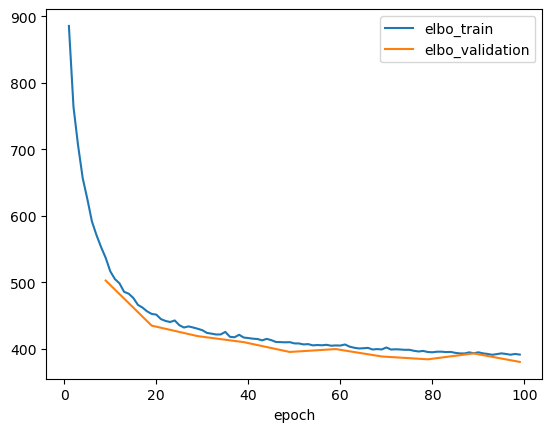

In [9]:
ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [10]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z

/tmp/ipykernel_1353/650095484.py:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgd.legendHandles:


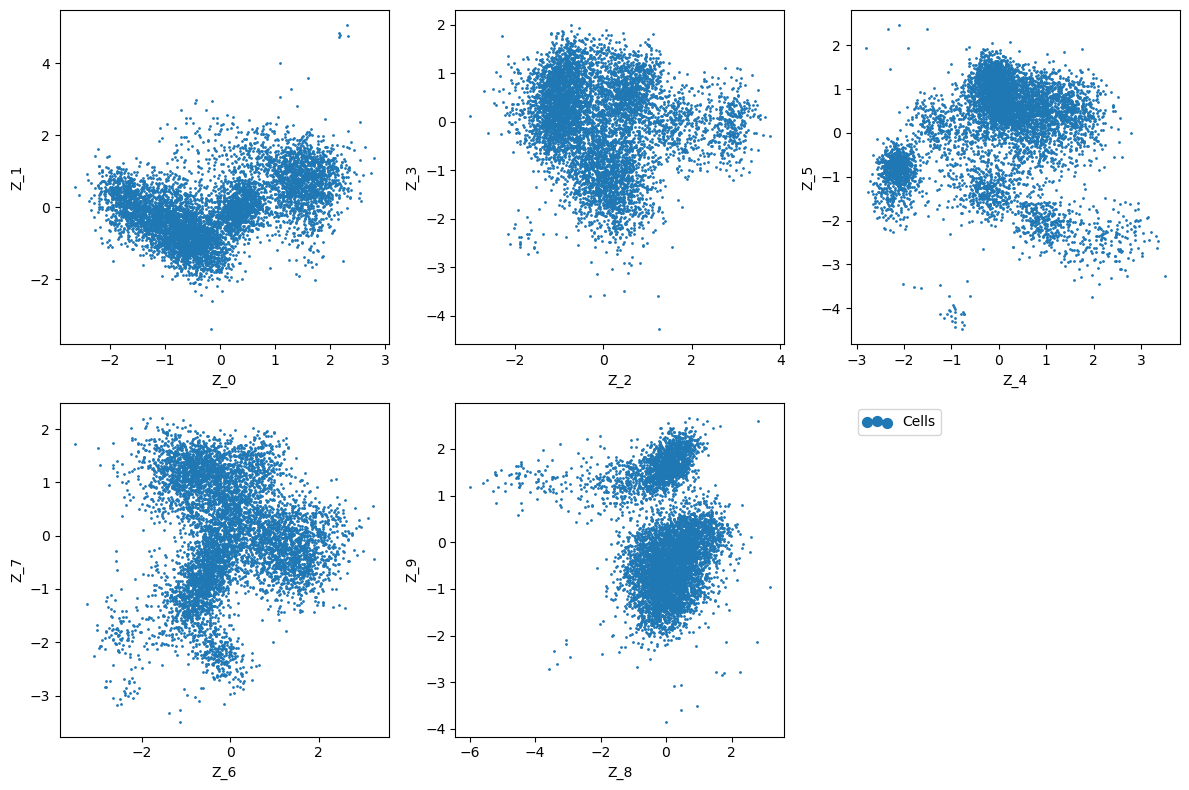

In [11]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(
        adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", s=4, label="Cells"
    )

    plt.xlabel(f"Z_{f}")
    plt.ylabel(f"Z_{f + 1}")

plt.subplot(2, 3, 6)
plt.scatter(
    adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", label="Cells", s=4
)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], c="w", label=None)
plt.gca().set_frame_on(False)
plt.gca().axis("off")

lgd = plt.legend(scatterpoints=3, loc="upper left")
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()

In [12]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
index,,,,,,,,,,
AL645608.8,0.137327,-0.195768,0.086146,0.067119,0.253213,0.009759,0.619608,0.259412,-0.346306,-0.145036
HES4,0.191103,-0.057703,0.076718,0.160214,0.103375,-0.175823,0.700525,0.113206,-0.752458,0.123892
ISG15,-0.172421,-0.657357,0.017508,-0.020233,0.118700,-0.060113,0.016195,0.362054,-0.244029,-0.152471
TNFRSF18,-0.562535,-1.110183,-0.518402,0.408810,0.563441,-0.714766,-0.274079,0.168511,0.384769,-1.084990
TNFRSF4,-0.741996,-1.100576,-0.495470,0.301702,0.672041,-0.103860,-0.183196,0.026579,0.126777,-1.256889


In [13]:
print(
    "Top loadings by magnitude\n---------------------------------------------------------------------------------------"
)
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ":\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.head(5).index])
    fstr += "\n\t...\n\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.tail(5).index])
    print(
        fstr
        + "\n---------------------------------------------------------------------------------------\n"
    )

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	GZMK, -2.7	TRGC2, -2.0	NELL2, -1.8	IL7R, -1.7	TRGC1, -1.7
	...
	CYP1B1, 0.76	NRGN, 0.78	S100A8, 0.81	RBP7, 0.82	P2RX1, 1.0
---------------------------------------------------------------------------------------

Z_1:	IFIT1, -1.6	CXCL10, -1.5	TIGIT, -1.4	MYOM2, -1.4	IFI44L, -1.2
	...
	CES1, 0.53	CAVIN3, 0.57	LINC02446, 0.59	RNASE1, 0.64	IGHA2, 0.64
---------------------------------------------------------------------------------------

Z_2:	CEBPD, -1.1	LTK, -0.99	LMNA, -0.93	MS4A6A, -0.81	COL5A3, -0.78
	...
	LINC02397, 1.1	FCRL1, 1.1	IGHD, 1.2	TCL1A, 1.2	FCER2, 1.3
---------------------------------------------------------------------------------------

Z_3:	PTK7, -1.3	TYMS, -1.1	CDKN3, -1.1	UHRF1, -1.1	LRRN3, -1.1
	...
	CCL3, 0.65	TNF, 0.67	FCRL3, 0.68	CCL3L1, 0.78	TWIST1, 0.82
---------------------------------------------------------------------------------------

Z_4:

In [14]:
adata.obsm["X_scVI"] = Z_hat
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/umap/distances.py:108

/local/data/anaconda3/envs/BT/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


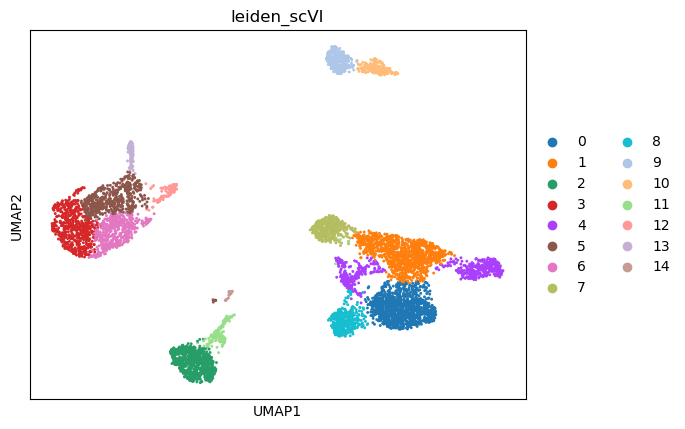

In [15]:
sc.pl.umap(adata, color=["leiden_scVI"])

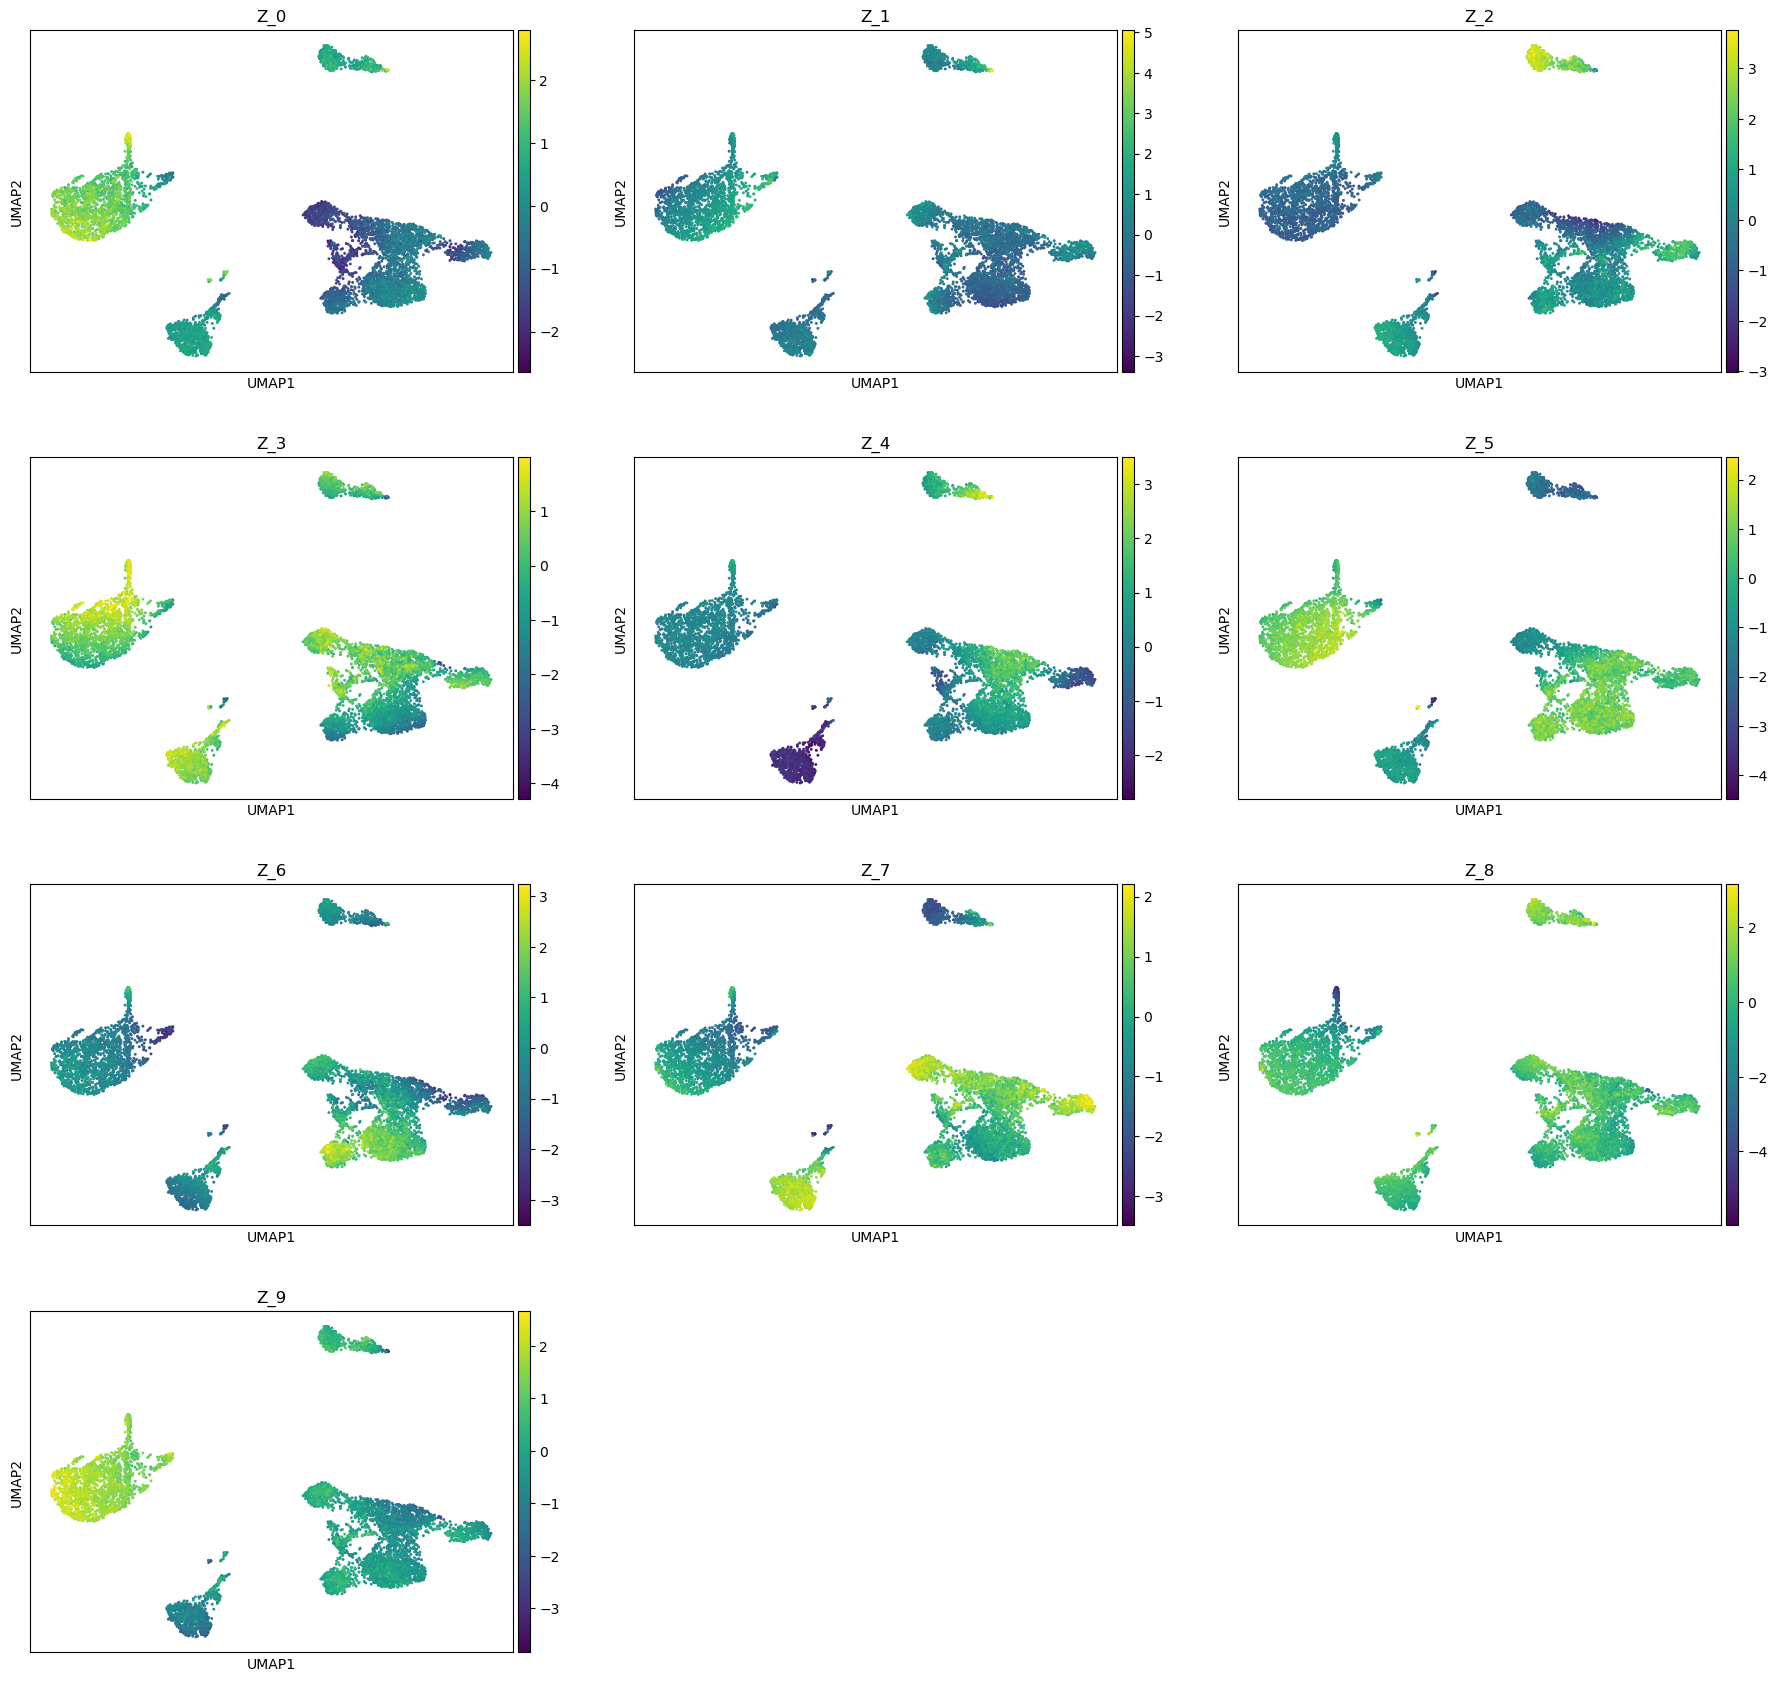

In [16]:
zs = [f"Z_{i}" for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3)

In [17]:
adata = scvi.data.heart_cell_atlas_subsampled()

INFO     Downloading file at data/hca_subsampled_20k.h5ad                                                          
Downloading...: 100%|██████████| 65714/65714.0 [00:00<00:00, 106742.33it/s]


In [18]:
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

In [ ]:
model = scvi.model.SCVI(adata)

In [11]:
model

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [12]:
model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|██████████| 400/400 [27:55<00:00,  4.31s/it, loss=281, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [27:55<00:00,  4.19s/it, loss=281, v_num=1]


/Applications/Anaconda/anaconda3/envs/ML/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Applications/Anaconda/anaconda3/envs/ML/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Applications/Anaconda/anaconda3/envs/ML/lib/python3.9/site-

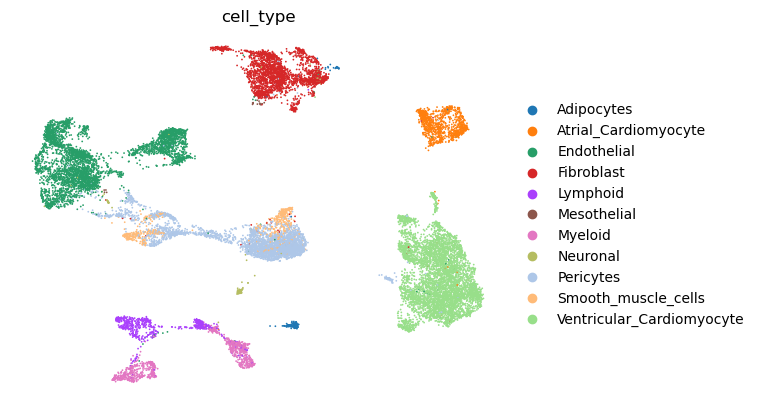

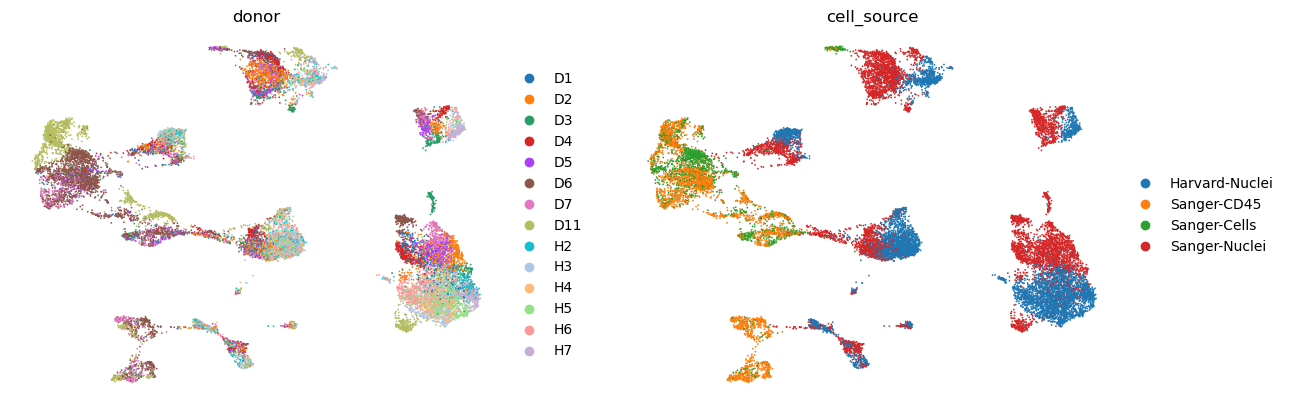

In [13]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

In [15]:
# use scVI latent space for UMAP generation
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)